# Demonstrate functions dealing with em follow-up

## new events from gracedb

In [10]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# credentials
import yaml

with open("../config/Credentials.yaml", "r") as file:
    credentials = yaml.safe_load(file)
fritz_token = credentials["fritz_token"]
allocation = credentials["allocation"]
kowalski_username = credentials["kowalski_username"]
kowalski_password = credentials["kowalski_password"]
github_token = credentials["github_token"]
zfps_email = credentials["zfps_email"]
zfps_userpass = credentials["zfps_userpass"]
zfps_auth_username = credentials["zfps_auth"]["username"]
zfps_auth_password = credentials["zfps_auth"]["password"]

In [6]:
req = [
    {
        "catalog": "catnorth",
        "submission_date": "2025-07-11 16:31:04.389",
        "action": "update",
        "num_agn_submitted": 12671,
        "num_batches_submitted": 9,
        "batch_ids": None,
        "number_returned": None,
        "number_broken_urls": None,
        "complete": True,
        "from_queue": True,
        "note": "unsuccessful update, no batches returned",
    }
]


num_zfps_requests_so_far = len([x for x in req if "from_queue" not in x.keys()])

num_zfps_requests_so_far

0

In [38]:
# TODO: remove cell when finished developing

import importlib
import flares_utils.new_events_utils
import trigger_utils.trigger_utils

# Reload the modules to ensure the latest version is used
importlib.reload(flares_utils.new_events_utils)
importlib.reload(trigger_utils.trigger_utils)
importlib.reload(flares_utils.photometry_utils)
importlib.reload(flares_utils.flares_utils)

<module 'flares_utils.flares_utils' from '/home/kira/mypy/repos/BBHBot/flares_utils/flares_utils.py'>

In [126]:
# get events from gracedb that we haven't already saved
from flares_utils.new_events_utils import GetSuperevents

params = GetSuperevents(
    path_data="../data",
    event_source="gracedb",
    observing_run="O4c",
    retrieve_all=False,
).get_new_events()

30 significant superevents in O4c
1 new events to process (cut 3 low prob bbh events)
Found: mchirp_source.json


In [127]:
# check the trigger status on fritz and check if we handled the event correctly
from flares_utils.new_events_utils import Fritz

eventid = [x[0] for x in params]
dateid = [x[12] for x in params]
a90 = [x[16] for x in params]
far = [x[9] for x in params]
mass = [x[22] for x in params]

trigger_status = Fritz(
    eventid,
    dateid,
    a90,
    far,
    mass,
    allocation,
    fritz_token,
    kowalski_username,
    kowalski_password,
).get_trigger_status()

found 1355 exposures of 295 unique fields between JD 2460866 and 2460869
found 14 / 14 fields observed in time period
Correct no trigger: serendipitous coverage for S250712cd
0 errors, 1 correct, 0 inspect


In [141]:
# compile event information and save to the dictionary of events

from flares_utils.new_events_utils import NewEventsToDict

df = NewEventsToDict(
    params, trigger_status, path_data="../data", testing=False
).save_data()
df

New events saved to dictionary.


,GW MJD,90% Area (deg2),50% Area (deg2),Distance (Gpc),FAR (years/FA),Mass (M_sol),Chirp Mass (left edge),gcnids,trigger,plan time,plan probability,plan start,cadence
graceids,,,,,,,,,,,,,
S250712cd,60869,155,31,2.44,2400,88,22,2025-07-12T14:25:32,triggered,0,1,2025-07-12T14:25:32.000,"[2025-07-19, 2025-07-26, 2025-08-02, 2025-08-0..."


In [171]:
# default arguments set at contour=90, mindec=-90
from flares_utils.new_events_utils import KowalskiCrossmatch

eventid = [x[0] for x in params]
skymap_str = [x[18] for x in params]
zmin = [x[19] for x in params]
zmax = [x[20] for x in params]

crossmatch = KowalskiCrossmatch(
    eventid,
    skymap_str,
    dateid,
    zmin,
    zmax,
    path_data="../data",
    testing=False,
    kowalski_username=kowalski_username,
    kowalski_password=kowalski_password,
)
matches = crossmatch.get_crossmatches()

1 events are missing crossmatch: ['S250712cd']
Crossmatching 1 events: ['S250712cd']
1129 CATNorth AGN found in localization volume for S250712cd
S250712cd replaced previously saved crossmatch


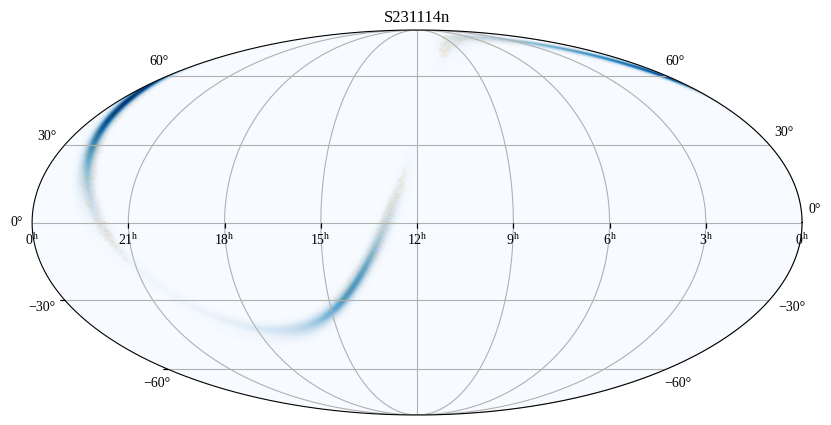

In [4]:
from flares_utils.new_events_utils import PlotSkymap

PlotSkymap(
    gracedbid="S231114n",
    path_data="../data",
    observing_run="O4a",
    catalog="agn_catnorth",
).plot(show_agn=True)

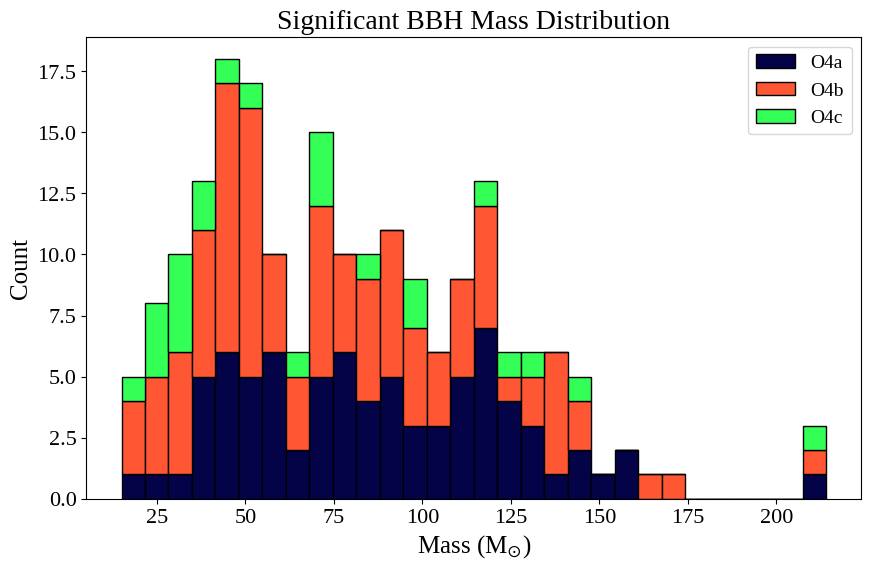

In [53]:
from flares_utils.new_events_utils import VisualizePop

VisualizePop(path_data="../data", observing_run=["O4a", "O4b", "O4c"]).plot_masses()

In [174]:
from flares_utils.new_events_utils import PushEventsPublic

summary_events = PushEventsPublic(
    path_data="../data", github_token=github_token, observing_run="O4c", testing=True
)

df, priority, trigger_df, error_triggers = summary_events.format_and_push()

3 O4c events with FAR > 10 and mchirp>22 (mass > 60) and area < 1000 sq deg


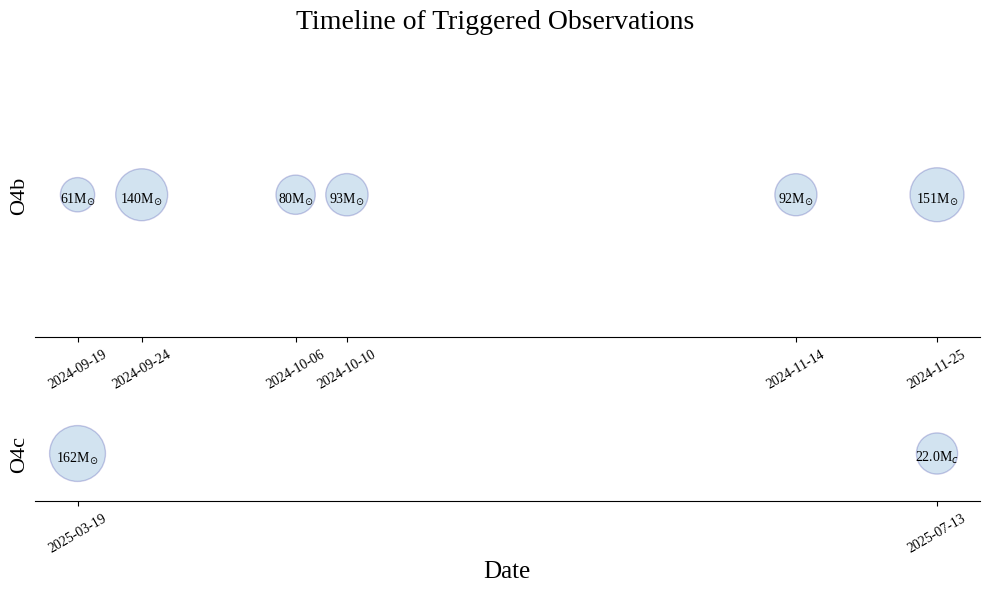

In [170]:
summary_events.plot_trigger_timeline()

# ZTF forced photometry service

In [13]:
# check photometry status

from flares_utils.photometry_utils import PhotometryStatus

PhotometryStatus(observing_run="O4c", path_data="../data").show_status()

15 / 17 events in O4c are not priority


,ID,Date last zfps,Status,Trigger
0,S250319bu,2025-07-01 18:26:40.812,update ZFPS,True
1,S250204ax,,needs ZFPS,


70 / 1612 dataframes for 4560 Catnorth sources are empty


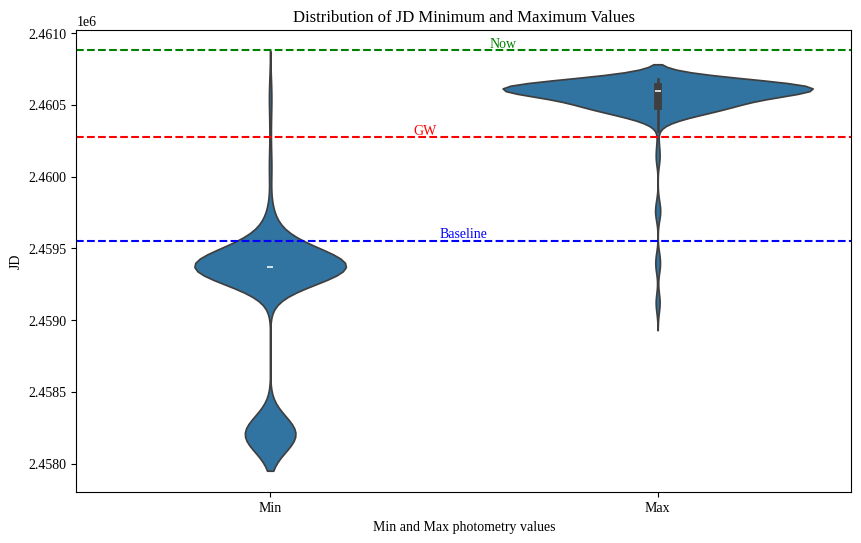

In [10]:
# check our photometry coverage

from flares_utils.photometry_utils import PlotPhotometry

PlotPhotometry(
    observing_run="O4a", graceid="S231123cg", path_data="../data"
).plot_photometry_dates()

In [11]:
from flares_utils.photometry_utils import PhotometryCoords

ra, dec, jd, num_agn = PhotometryCoords(
    action="all",
    graceid="S231123cg",
    catalog=["catnorth"],
    verbose=True,
    path_data="../data",
    observing_run="O4a",
).get_photometry_coords()

about 4506 / 4560 coords should be in ZTF footprint
Submit in 4 batches


In [12]:
from flares_utils.photometry_utils import GetPhotometry

submit = GetPhotometry(
    ra,
    dec,
    jd,
    graceid="S231123cg",
    auth_username=zfps_auth_username,
    auth_password=zfps_auth_password,
    email=zfps_email,
    userpass=zfps_userpass,
    observing_run="O4a",
    path_data="../data",
    testing=True,
).submit()

submit in 4 batches
Success
Success
Success
Success
Submitted 4506 AGN in 4 batches at 2025-07-22 20:10:13.263


In [9]:
submit  # S231114n = ('2025-07-22 19:59:50.461', 2156, 2)

('2025-07-22 19:59:50.461', 2156, 2)

In [18]:
from flares_utils.photometry_utils import SavePhotometry

# date_submitted = submit[0]
# num_batches = submit[2]

date_submitted = "2025-07-22 20:10:13.263"
num_batches = 2

save_results = SavePhotometry(
    graceid="S231114n",
    action="all",
    path_data="../data",
    submission_date=date_submitted,
    num_batches_submitted=num_batches,
    observing_run="O4a",
    testing=False,
    email=zfps_email,
    userpass=zfps_userpass,
    auth_username=zfps_auth_username,
    auth_password=zfps_auth_password,
).save()

20250724_23:19:49: Script executed normally and queried the ZTF Batch Forced Photometry database.

20250724_23:19:54: Script executed normally and queried the ZTF Batch Forced Photometry database.

20250724_23:19:54: ('Retrieved', 2154, 'lightcurves')
20250724_23:23:43: 50 broken urls; 2104 lightcurves returned
20250724_23:24:06: downloaded 2104 lightcurves


## rolling window heuristic for flares

In [20]:
from flares_utils.flares_utils import FlarePreprocessing

AGN = FlarePreprocessing(
    graceid="S231123cg", path_data="../data", observing_run="O4a"
).process_for_flare()

20250724_23:28:57: found 4454 AGN


In [21]:
# default arguments window_size_before=50, window_size_after=25, baseline_years=2

from flares_utils.flares_utils import RollingWindowStats

stats = RollingWindowStats(
    graceid="S231123cg",
    agn=AGN,
    path_data="../data",
    window_size_before=50,
    window_size_after=25,
    baseline_years=2,
    observing_run="O4a",
).get_rolling_window_stats()

In [41]:
# k_mad defines the scalar on the mean absolute deviations that a point in the GW window must be brighter than,
# percent defines the percentage of baseline medians that must meet this criteria

from flares_utils.flares_utils import RollingWindowHeuristic

g, r, i, gr, gri = RollingWindowHeuristic(
    graceid="S231123cg",
    agn=AGN,
    rolling_stats=stats,
    path_data="../data",
    observing_run="O4c",
    testing=False,
    percent=1,
    k_mad=5,
).get_flares(custom_filter_name="tighter_filter")

20250724_23:55:51: in g,r,i we find 500,508,403 candidates
20250724_23:55:51: 898 unique flares across all colors
20250724_23:55:51: 299 AGN have flares in g and r filters
20250724_23:55:51: 146 AGN have flares in g, r, and i filters
20250724_23:55:51: 404 / 4454 have no observations in any color in 200 day post GW period
20250724_23:55:51: 249 / 4454 have no observations in any color before the GW detection
20250724_23:55:51: saved flare data for S231123cg to ../data/flare_data/flares/S231123cg_tighter_filter.json


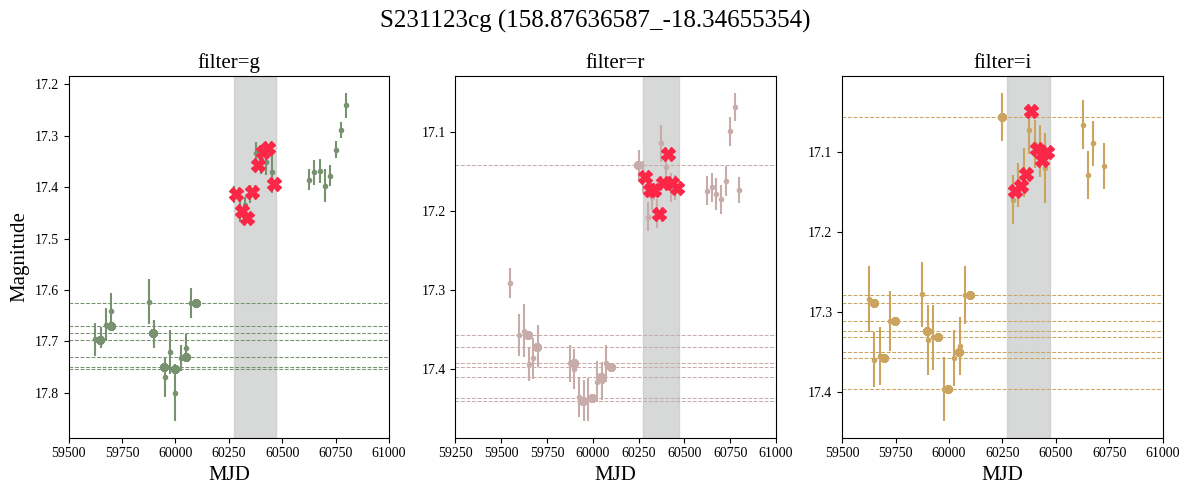

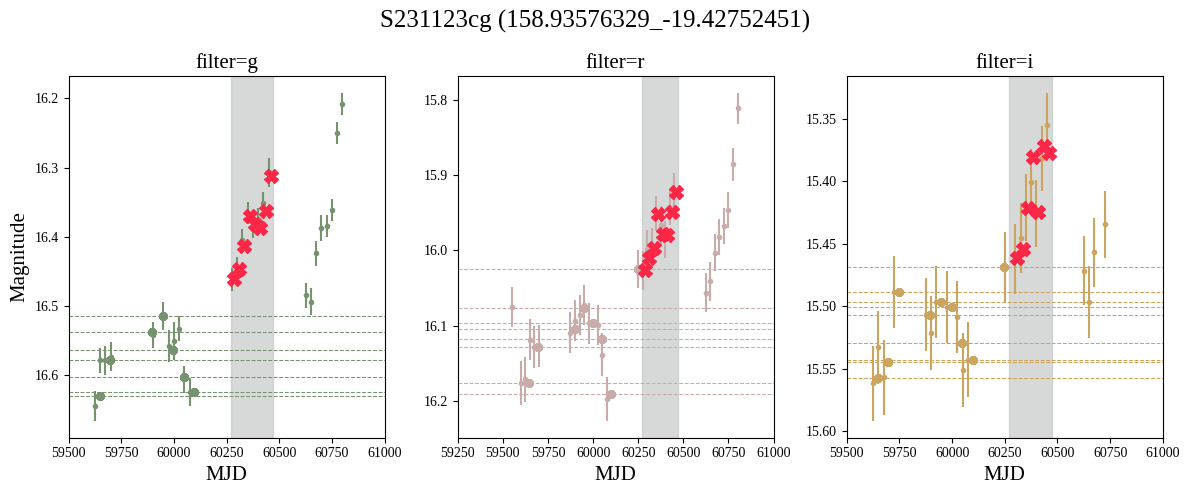

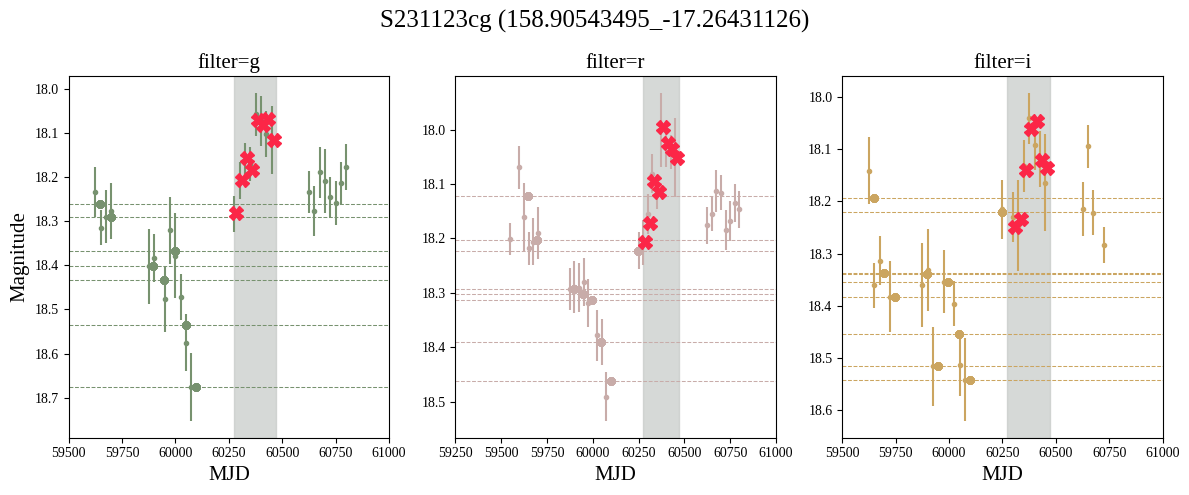

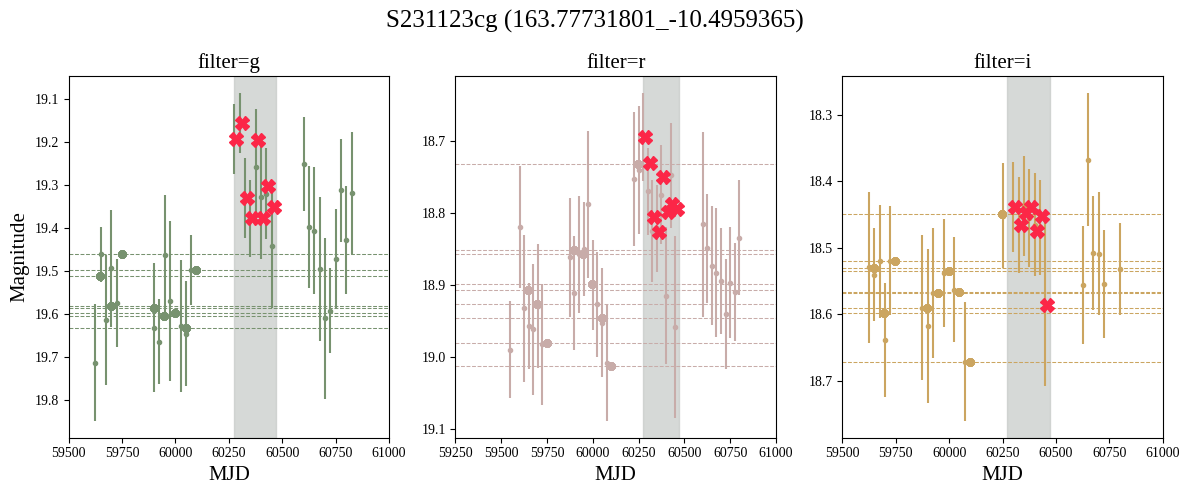

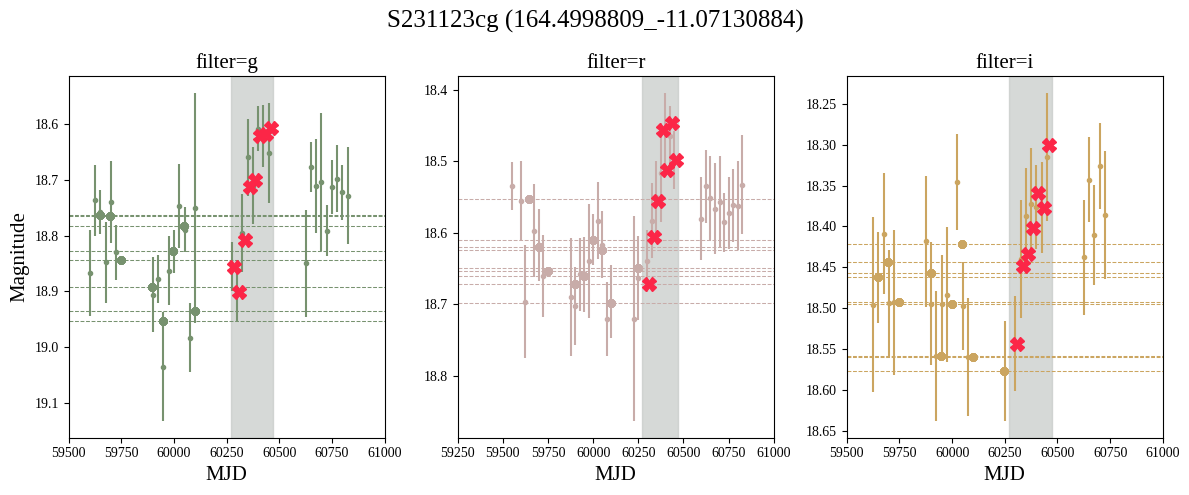

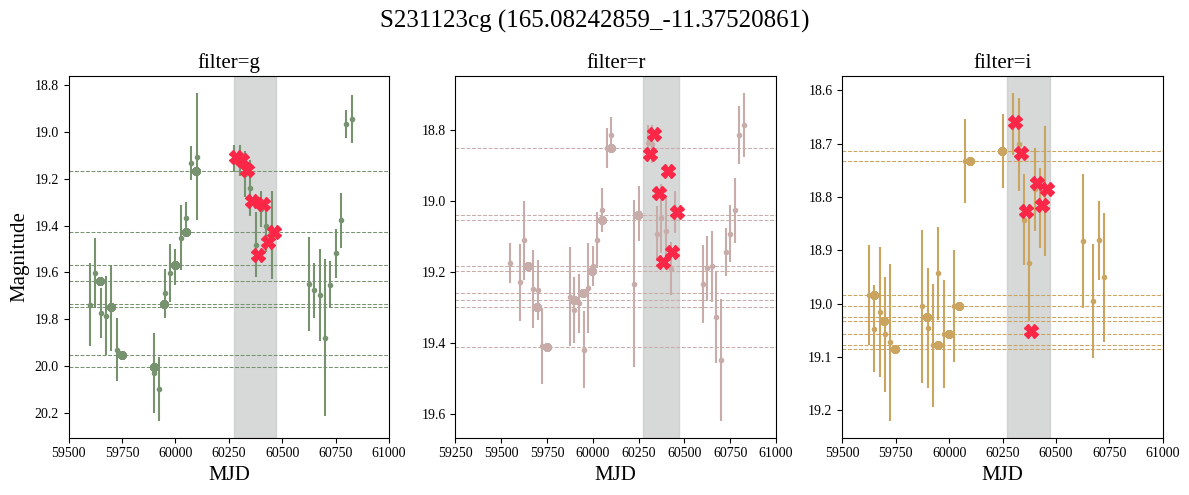

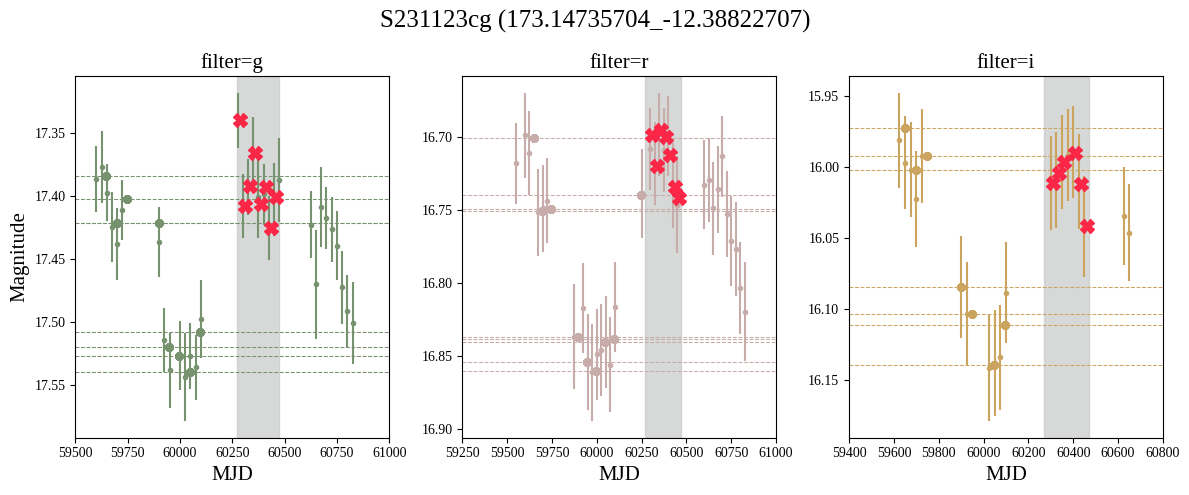

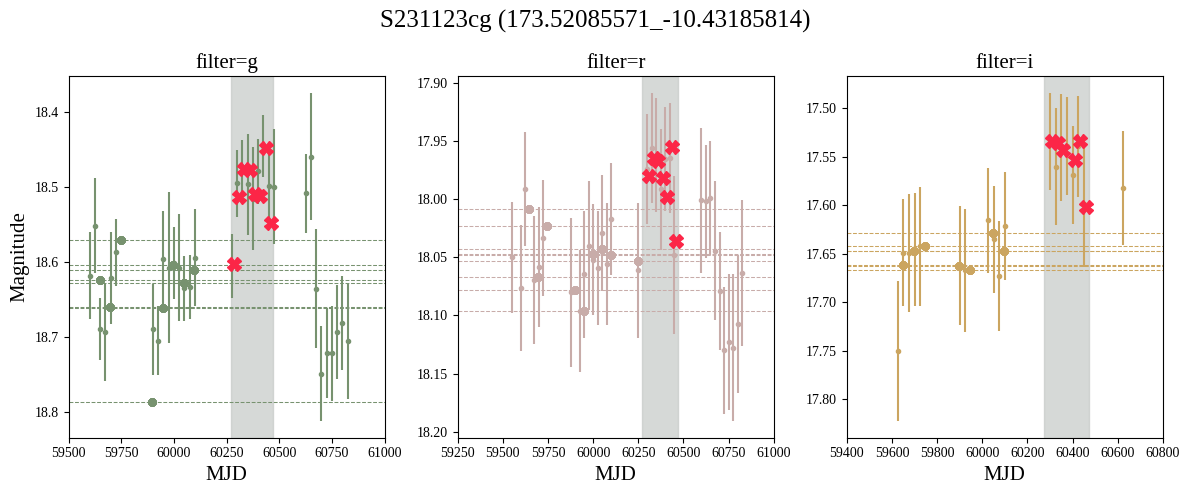

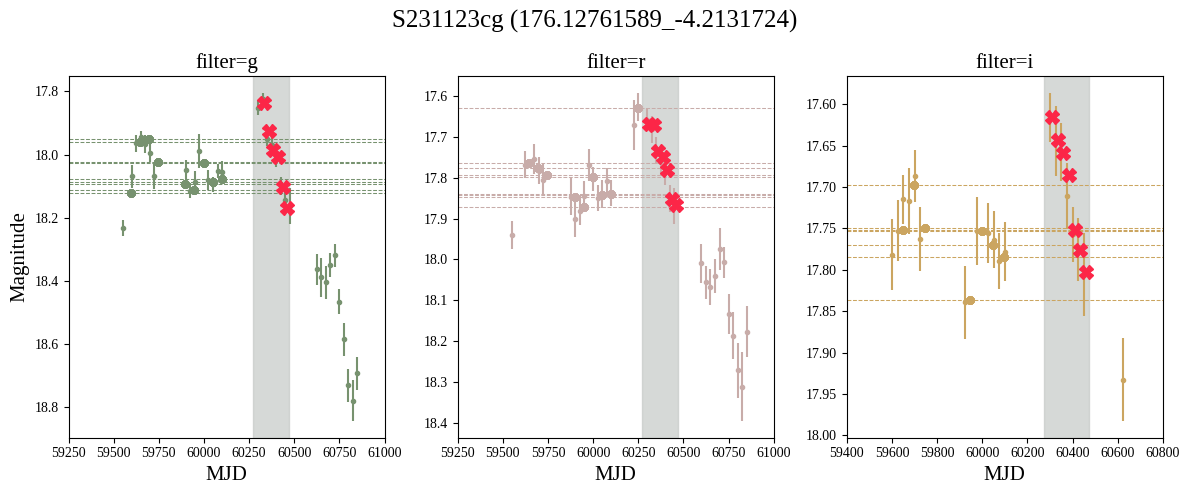

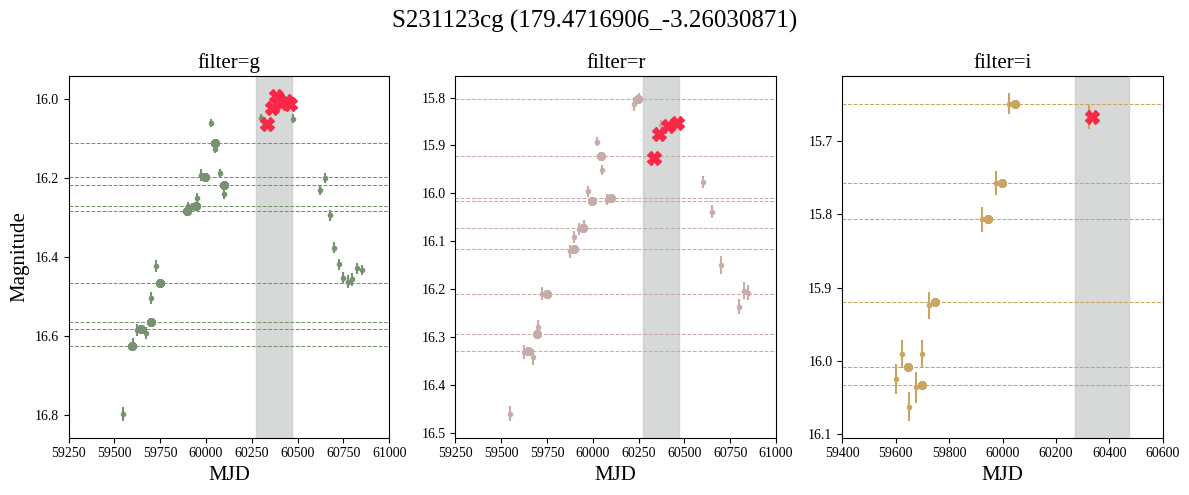

[None, None, None, None, None, None, None, None, None, None]

In [40]:
# plot given the values defined above
from flares_utils.flares_utils import Plotter

# plot from an index:
plot_index = gr[0:10].tolist()
[
    Plotter(
        index_to_plot=[i],
        color_to_plot="all",
        agn=AGN,
        rolling_stats=stats,
        graceid="S231123cg",
        path_data="../data",
        observing_run="O4a",
    ).show_plots()
    for i in plot_index
]

# plot matches from a fully processed graceid

In [6]:
# plot given only a graceid
# first load the data, wont plot heuristic because do not save stats

from flares_utils.flares_utils import FlarePreprocessing
from flares_utils.flares_utils import Plotter

graceid = "S250319bu"

AGN = FlarePreprocessing(
    graceid=graceid, path_data="../data", observing_run="O4c"
).process_for_flare()

found 23880 AGN


1881 AGN have flares in gr band(s)


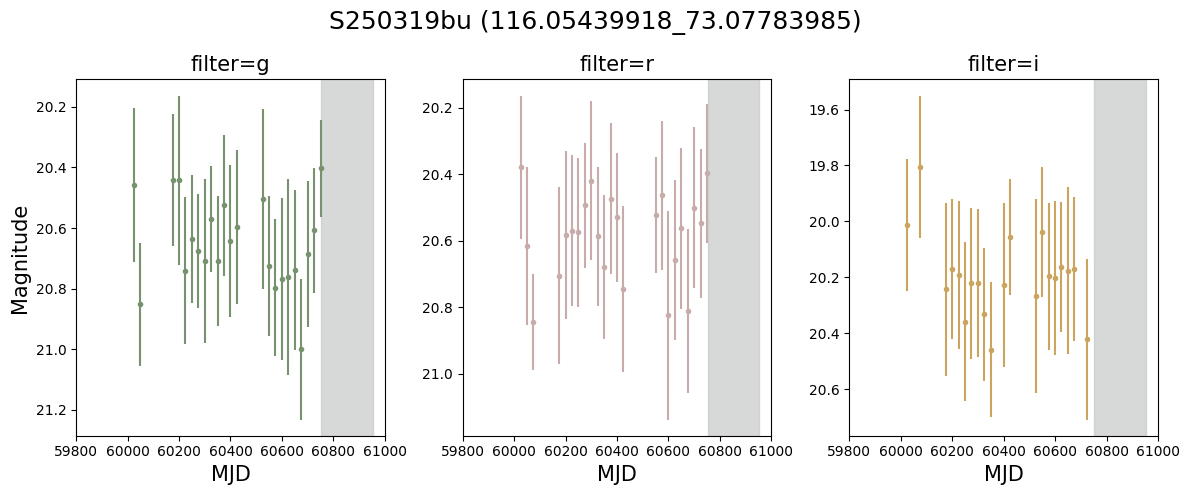

In [39]:
# if flares_from_gracid argument is provided, will only plot AGN with flares in those bands

index_to_plot = [32]

Plotter(
    index_to_plot=index_to_plot,
    color_to_plot="all",
    agn=AGN,
    rolling_stats=None,
    graceid=graceid,
    path_data="../data",
    observing_run="O4c",
    flares_from_graceid="gr",
).show_plots()